In [25]:
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
% matplotlib inline
import seaborn as sns
sns.set(context='paper',
style='darkgrid',
rc={'figure.facecolor':'white'},
font_scale=1.2)

In [2]:
# predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, 
# the local property tax rate, and so on. The dataset you’ll use has an interesting difference from the two previous examples. It has relatively few data 
# points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different 
# scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

In [8]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [14]:
print(train_data.shape, train_targets.shape, 
      test_data.shape, test_targets.shape)

(404, 13) (404,) (102, 13) (102,)


In [5]:
# you have 404 training samples and 102 test samples, each with 13 numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on.

In [13]:
train_targets[:50]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1])

In [15]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [16]:
# Preparing the data
# hetrogenous data ranges for price, crime is difficult
# best practice is to feature wise normalizations z-scored
# for each features, subtract mean and divide by std
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [17]:
# . Model definition
# small data == overfitting, so start with simple layer
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()    
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # mean squared erro mse for regression
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# Regression output is single unit and 
#  no activation (it will be a linear layer).
# Predict a single value
 

In [19]:
# K-fold validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Builds the Keras model (already compiled)
    model = build_model()             
    # Trains the model (in silent mode, verbose = 0)
    model.fit(partial_train_data, partial_train_targets,                     
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluates the model on the validation data
    # mean absolute error (MAE)
    # Mean squared error (MSE)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


processing fold # 1


processing fold # 2


processing fold # 3


In [20]:
all_scores 

[2.111076261737559, 2.141618261242857, 2.9750924771374994, 2.453356902788181]

In [21]:
np.mean(all_scores)

2.4202859757265243

In [22]:
# Let’s try training the network a bit longer: 500 epochs. 
# To keep a record of how well the model does at each epoch, you’ll modify
# the training loop to save the per-epoch validation score log.
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # 1 Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # 2 Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 3 Builds the Keras model (already compiled)
    model = build_model()
    # 4 Trains the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,           
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0


processing fold # 1


processing fold # 2


processing fold # 3


In [23]:
# Building the history of successive mean K-fold validation scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


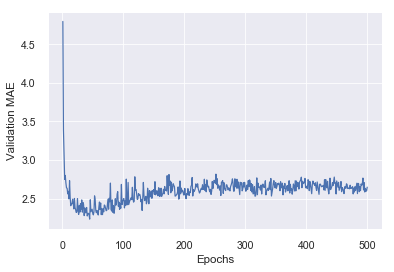

In [26]:
# plot Validation MAE by epoch
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()







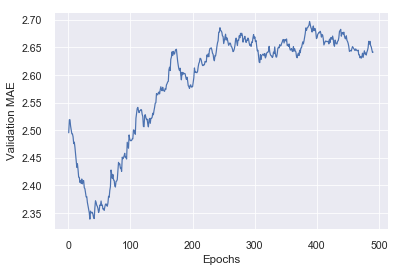

In [27]:
#  Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [28]:
# Training the final model
# Gets a fresh, compiled model
model = build_model()                                                     
# Trains it on the entirety of the data
model.fit(train_data, train_targets,                                      
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

 32/102 [========>.....................] - ETA: 0s

102/102 [==============================] - 0s 557us/step


2.6927915367425657